In [21]:
#Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import matplotlib.pyplot as plt

In [22]:
#Load Dataset
df = pd.read_csv("Bengaluru_House_Dataset.csv")

In [23]:
#View Initial Data
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [24]:
#Drop Unnecessary Columns
df = df.drop(['area_type', 'society', 'balcony', 'availability'], axis=1)

In [25]:
#Drop Null Values
df = df.dropna()

In [26]:
#Add 'bhk' Column from 'size'
df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]))

In [27]:
#Convert 'total_sqft' to Numeric
def is_float(x):
    try:
        float(x)
        return True
    except:
        return False

def convert_sqft_into_number(x):
    try:
        tokens = x.split('-')
        if len(tokens) == 2:
            return (float(tokens[0]) + float(tokens[1])) / 2
        return float(x)
    except:
        return None

df['total_sqft'] = df['total_sqft'].apply(convert_sqft_into_number)
df = df.dropna()


In [28]:
#Create 'price_per_sqft'
df['price_per_sqft'] = df['price']*100000 / df['total_sqft']

In [29]:
#Clean 'location' Field
df['location'] = df['location'].apply(lambda x: x.strip())
location_stats = df['location'].value_counts()
location_less_than_10 = location_stats[location_stats <= 10]
df['location'] = df['location'].apply(lambda x: 'other' if x in location_less_than_10 else x)

In [30]:
#Remove Outliers Where Total Sqft Per BHK < 300
df = df[~(df.total_sqft / df.bhk < 300)]

In [31]:
#Remove Outliers in Price Per Sqft per Location
def remove_outlier_from_price_per_sqft(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft > (m - st)) & (subdf.price_per_sqft <= (m + st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

df = remove_outlier_from_price_per_sqft(df)


In [32]:
#Remove BHK Outliers
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk - 1)
            if stats and stats['count'] > 5:
                exclude_indices = np.append(
                    exclude_indices,
                    bhk_df[bhk_df.price_per_sqft < stats['mean']].index.values
                )
    return df.drop(exclude_indices, axis='index')

df = remove_bhk_outliers(df)


In [33]:
#Remove Bathroom Outliers
df = df[df.bath < df.bhk + 2]

In [34]:
#Final Data for Model
df_model = df.drop(['size', 'price_per_sqft'], axis=1)
dummies = pd.get_dummies(df_model['location'])
df_model = pd.concat([df_model, dummies.drop('other', axis=1)], axis=1)
df_model = df_model.drop('location', axis=1)


In [35]:
#Split Features and Target
X = df_model.drop(['price'], axis=1)
y = df_model['price']


In [36]:
#Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


In [37]:
#Train Linear Regression Model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)


LinearRegression()

In [38]:
#Evaluate Model
print("Model Accuracy (R^2 score):", lr.score(X_test, y_test))


Model Accuracy (R^2 score): 0.8629132245229444


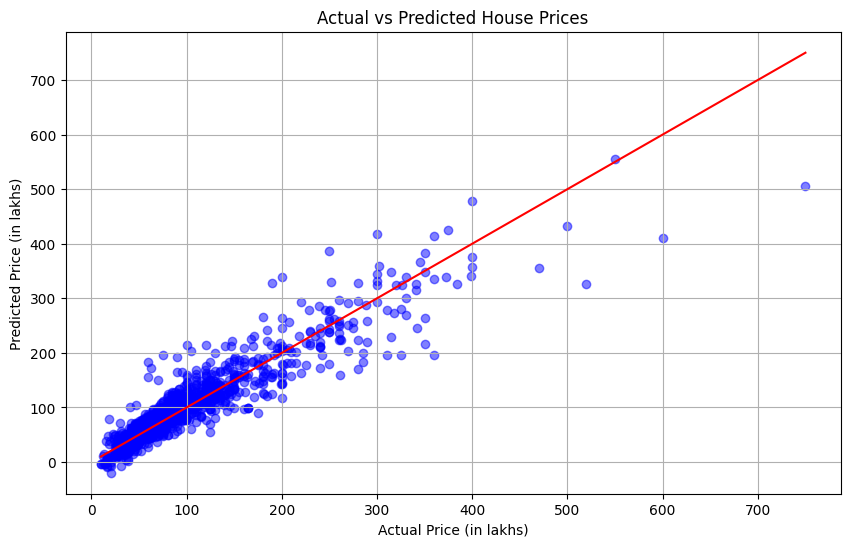

In [39]:
#Predict Prices on Test Set and Plot
y_pred = lr.predict(X_test)
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.xlabel("Actual Price (in lakhs)")
plt.ylabel("Predicted Price (in lakhs)")
plt.title("Actual vs Predicted House Prices")
plt.grid(True)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')  # 45-degree line
plt.show()


In [40]:
#Define Function to Predict Price for New Input
def predict_price(location, sqft, bath, bhk):
    loc_index = np.where(X.columns == location)[0][0] if location in X.columns else -1

    x_input = np.zeros(len(X.columns))
    x_input[0] = sqft
    x_input[1] = bath
    x_input[2] = bhk
    if loc_index >= 0:
        x_input[loc_index] = 1

    return lr.predict([x_input])[0]


In [41]:
# Use the Function to Make Predictions
predicted_price = predict_price('Whitefield', 1000, 2, 2)
print(f"Predicted price: ₹{predicted_price:.2f} lakhs")

Predicted price: ₹53.73 lakhs


c:\Users\chinm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [42]:
# Save model
joblib.dump(lr, "bangalore_house_price_model.pkl")

# Also save the column names (for prediction later)
import json

columns = {
    "data_columns": [col for col in X.columns]
}
with open("columns.json", "w") as f:
    f.write(json.dumps(columns))
